<h1 align=center><font size = 5>Grad-Cam </h1 >


<h3>Objective for this Notebook</h3>
<h5> 1. 了解Grad-Cam如何操作</h5>

In [21]:
!pip install grad-cam

DEPRECATION: Loading egg at c:\users\tony1\anaconda3\envs\pytorch\lib\site-packages\pycocotools-2.0-py3.12-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


# 以ResNet為例

C:\Users\tony1\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tony1\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Top-1 類別 index: 281


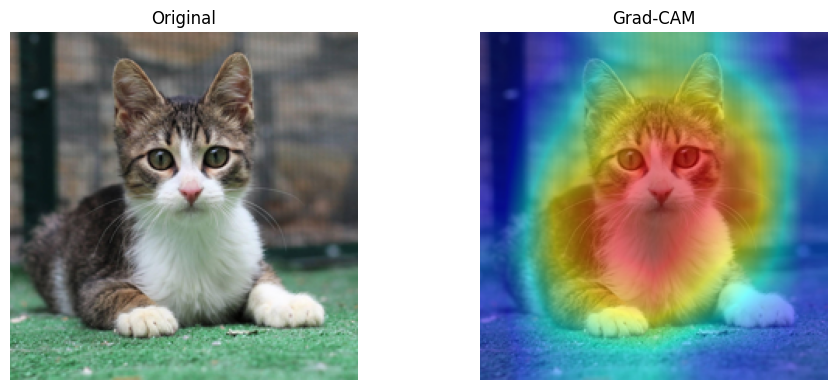

In [22]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from torchvision.models import resnet50
from torchvision import transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 1. 載入模型
model = resnet50(pretrained=True)
model.eval()

# 2. 指定目標層（通常是最後的卷積層）
target_layers = [model.layer4[-1]]

# 3. 載入與預處理圖片
image_path = "image.jpg"  # 換成你自己的圖片路徑
img = Image.open(image_path).convert("RGB").resize((224, 224))
img_np = np.float32(img) / 255.0  # 轉成 numpy 並正規化到 0~1

# Preprocess to tensor (for model input)
input_tensor = preprocess_image(img_np, mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

# 4. 預測 → 取 top-1 類別作為 target
with torch.no_grad():
    output = model(input_tensor)
    class_idx = output.argmax().item()
    print("Top-1 類別 index:", class_idx)

targets = [ClassifierOutputTarget(class_idx)]

# 5. 建立 Grad-CAM 物件（裝置會自動偵測）
cam = GradCAM(model=model, target_layers=target_layers)

# 6. 執行 CAM，回傳heatmap（shape: [H, W]）
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # batch 第0張

# 7. 疊圖顯示
cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title("Grad-CAM")
plt.axis("off")

plt.tight_layout()
plt.show()


# 使用gradio GUI套件展示Grad-Cam

In [23]:
import gradio as gr
import torch
import numpy as np
from PIL import Image
from torchvision.models import resnet50
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 載入模型
model = resnet50(pretrained=True)
model.eval()
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# 預處理函式
def run_gradcam(image: Image.Image):
    # 預處理
    image = image.convert("RGB").resize((224, 224))
    img_np = np.float32(image) / 255.0
    input_tensor = preprocess_image(img_np, mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
    with torch.no_grad():
        output = model(input_tensor)
        class_idx = output.argmax().item()

    # Grad-CAM
    targets = [ClassifierOutputTarget(class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    # 回傳為 PIL.Image 格式
    cam_image = np.uint8(255 * cam_image)
    return Image.fromarray(cam_image)

# 建立 Gradio 介面
interface = gr.Interface(
    fn=run_gradcam,
    inputs=gr.Image(type="pil"),
    outputs=gr.Image(type="pil"),
    title="🔍 ResNet50 Grad-CAM Demo",
    description="上傳一張圖片，看看模型在注意哪些區域"
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
